In [780]:
import sys
import importlib
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import *

In [781]:
# Get analytical solution of the BVP for given q0, p0 and t
def analytic_solution(bv, t, w=1):
    q0 = bv[:,None,0] 
    p0 = bv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    return torch.stack((x, y), dim=2)

In [782]:
def get_data(num_bv=10, num_t=10, Tmax=5):
    bv = np.random.uniform(low=-1, high=1, size=(num_bv, 2)).astype(np.float32)

    if num_t > 1:
        t = np.random.uniform(low=0, high=Tmax, size=(num_t, 1)).astype(np.float32)
    else:
        t = np.array([Tmax])[:,None].astype(np.float32)

    y = analytic_solution(bv, t)
    X = (bv, t)
    
    return X, y

In [783]:
X_test, y_test = get_data()
X_train, y_train = get_data()

In [784]:
net = DeepONet([40, 40, 40], [40, 40, 40], dim=2, K=2, activation='tanh', conserve_energy=True)
model = Model(X_train, y_train, X_test, y_test, net)
model.train(iterations=1_000)

Step 	 Train loss 	 Test loss
100 	 [1.06e-01] 	 [9.85e-02] 	 New best model!
200 	 [1.05e-01] 	 [9.25e-02] 	 New best model!
300 	 [1.05e-01] 	 [9.12e-02] 	 New best model!
400 	 [1.04e-01] 	 [9.04e-02] 	 New best model!
500 	 [1.04e-01] 	 [9.00e-02] 	 New best model!
600 	 [1.04e-01] 	 [8.96e-02] 	 New best model!
700 	 [1.04e-01] 	 [8.94e-02] 	 New best model!
800 	 [1.04e-01] 	 [8.97e-02] 	 
900 	 [1.03e-01] 	 [8.92e-02] 	 New best model!
1000 	 [1.04e-01] 	 [8.92e-02] 	 


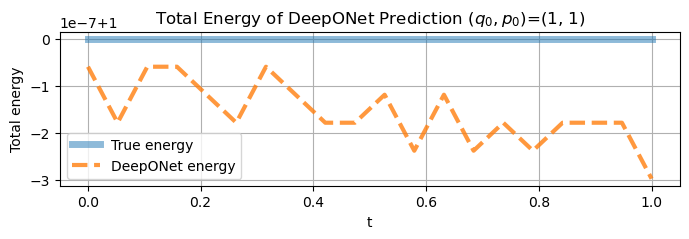

In [785]:
model.plot_energy()

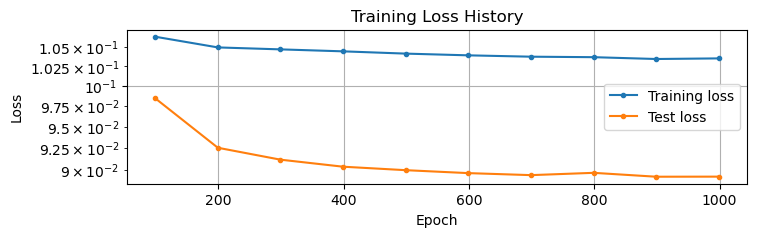

In [786]:
model.plot_losshistory()

In [787]:
def test_symplecticity(model, T, num_pts=100):

            
    grid_points = torch.linspace(-1, 1, num_pts, requires_grad=True, dtype=torch.float32)
    mesh = torch.cartesian_prod(grid_points, grid_points)
    t = torch.tensor([T], requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    u = model.net(mesh, t)[:,0,:]


    D = torch.stack([grad(u[:,i], mesh, grad_outputs=torch.ones_like(u[:,i]), retain_graph=True)[0] for i in range(u.shape[1])], axis=-1)
    
    

    
    
    J = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)
    
    DTJD = torch.matmul(D.transpose(1, 2), torch.matmul(J, D))
    
    deltaJ = torch.linalg.norm(DTJD - J, ord=2, dim=(1, 2))

    #det = row1[:,0]*row2[:,1] - row1[:,1]*row2[:,0]  

    deltaJ = deltaJ.numpy().reshape(num_pts, num_pts)
    plt.figure(figsize=(8, 6))
    plt.imshow(det, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    plt.colorbar(label='$\Delta J$')
    plt.title("$\Delta J = || \\nabla \mathcal{N}(t)^T J \\nabla \mathcal{N}(t) - J||/||J||$ over $(q,p)$-grid, for t=" + f"{T}")
    plt.xlabel('q')
    plt.ylabel('p')
    plt.show()

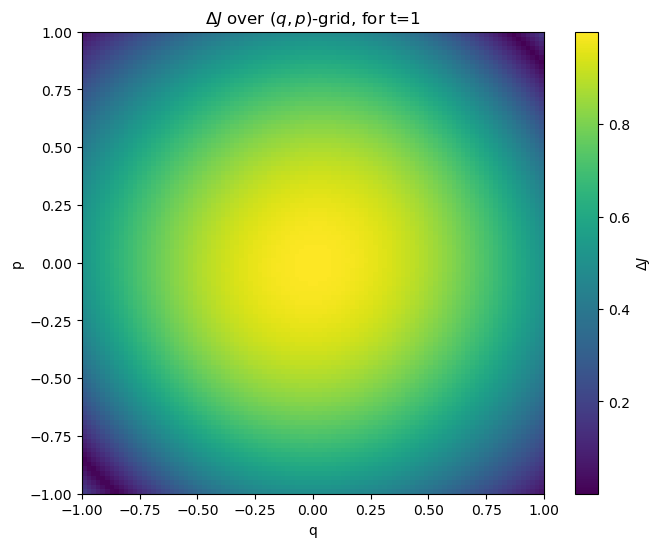

In [788]:
model.plot_symplecticity(T=1, num_pts=100)

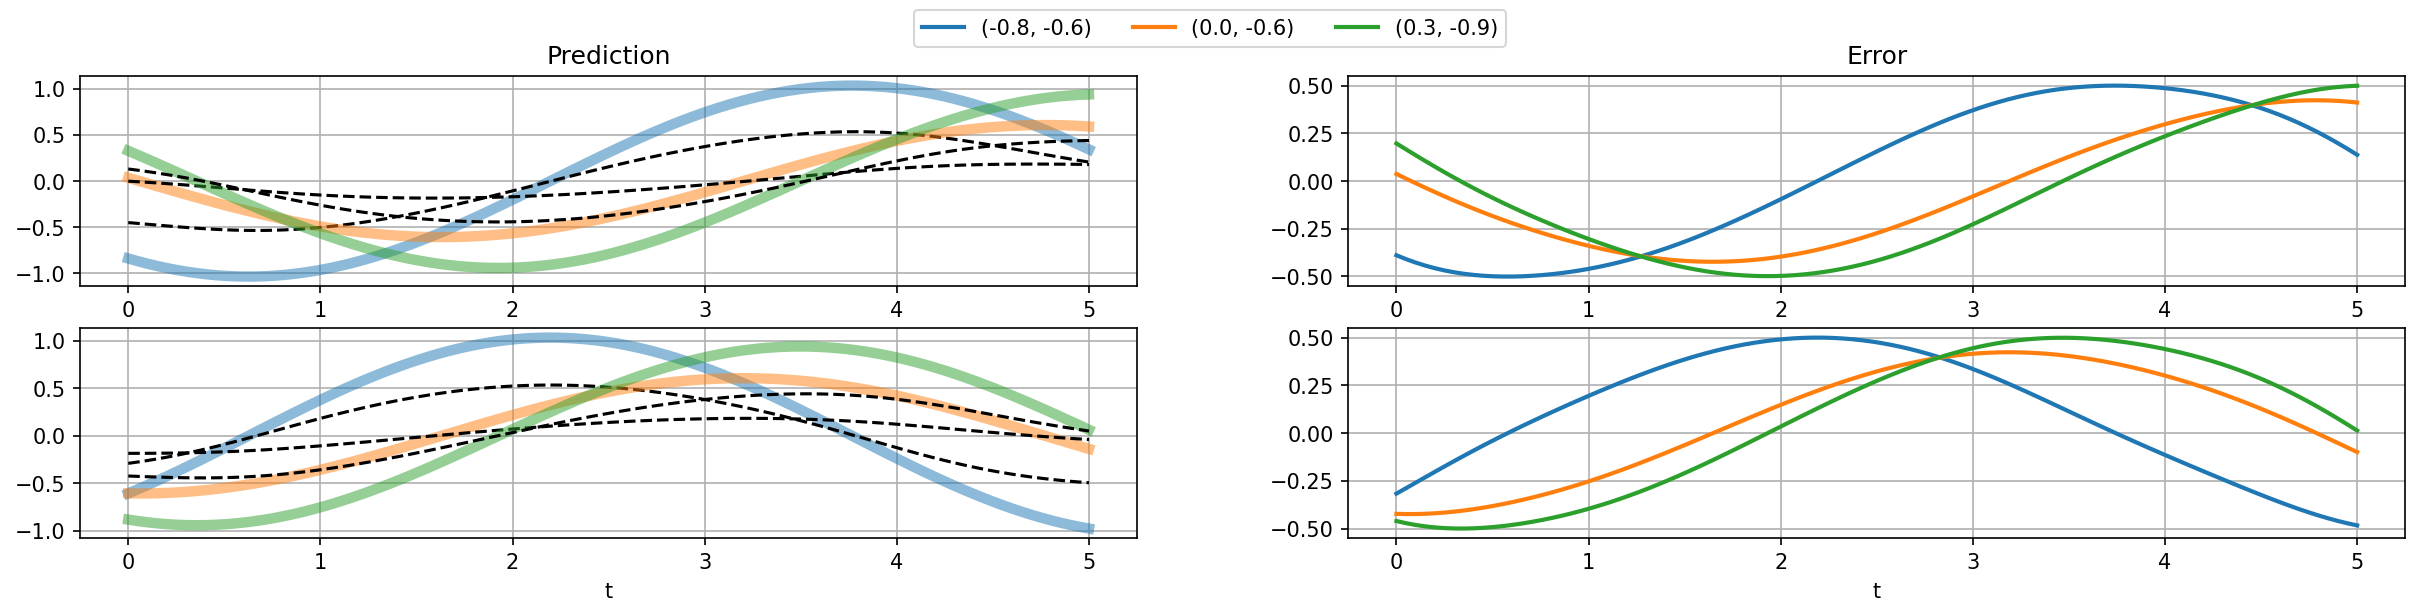

In [789]:
model.plot_full_predictions(Tmax=5, solver=analytic_solution)

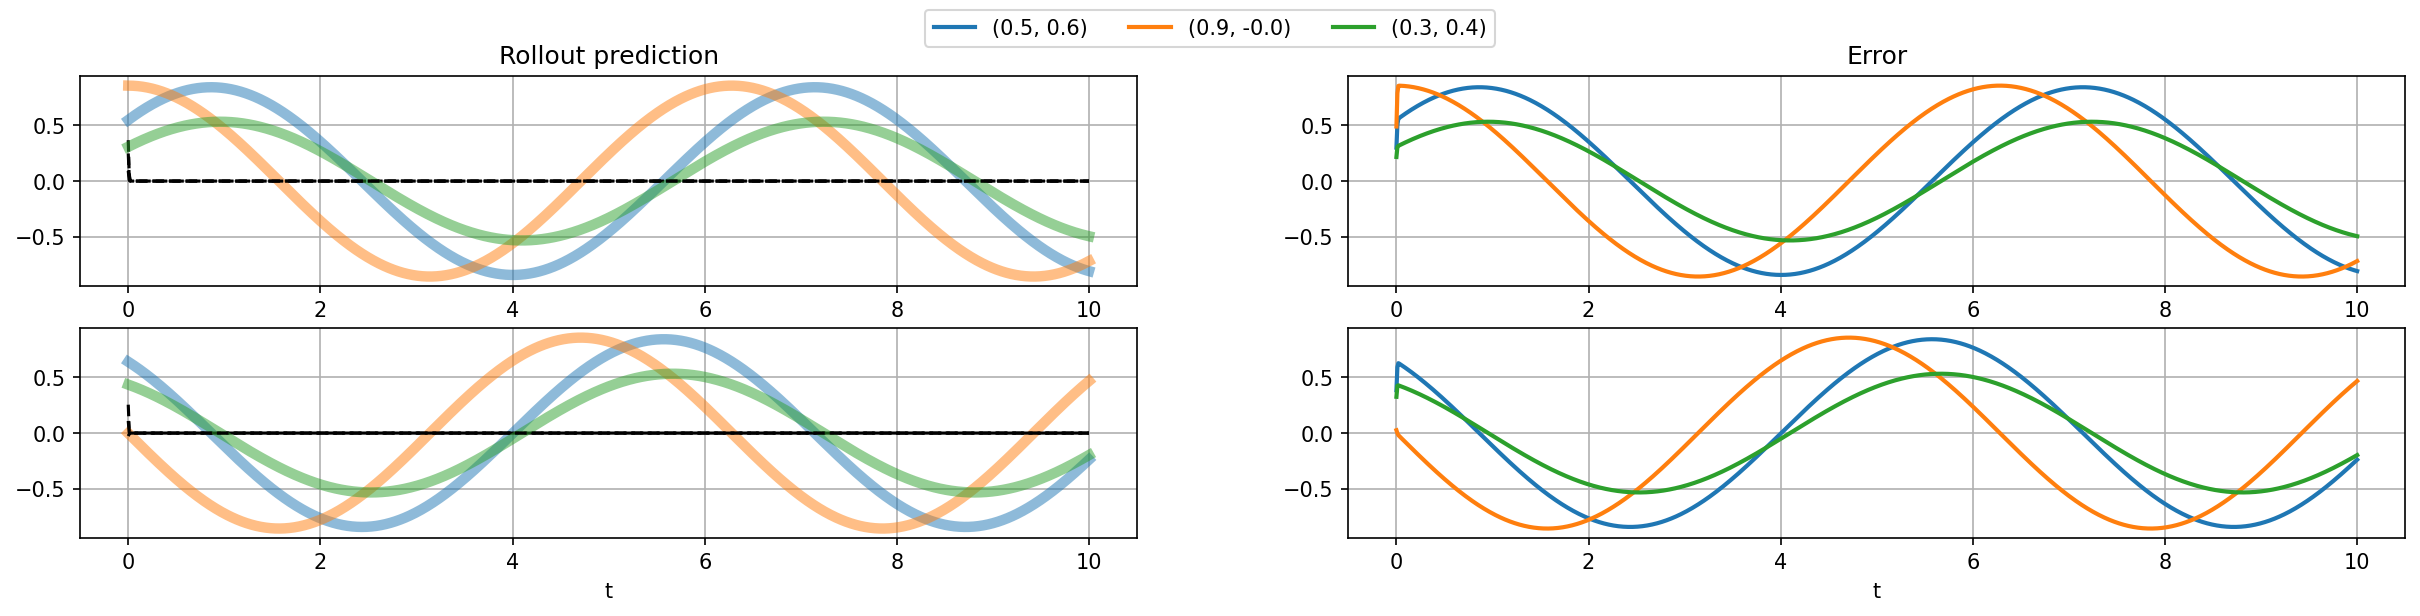

In [790]:
model.plot_rollout_predictions(solver=analytic_solution)